# Wind Capacity Prediction

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from enum import Enum

from ngboost.scores import LogScore
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import Exponential, Normal, LogNormal

from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error

from scipy.stats import norm



paths = {"era5_eu_2013": "../resources/europe-2013-era5.nc",
         "era5_tutorial": "../resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "../resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "../resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "../resources/capfacs_37.csv",
         "era5_regions": "../resources/europe-2013-era5-regions.nc"}

In [2]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:           (region: 65, time: 8760)
Coordinates:
  * region            (region) object 'AL0 0 on' 'AT0 0 on' ... 'SI0 0 off'
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    height            (region, time) float64 ...
    wnd100m           (region, time) float64 ...
    roughness         (region, time) float64 ...
    influx_toa        (region, time) float64 ...
    influx_direct     (region, time) float64 ...
    influx_diffuse    (region, time) float64 ...
    albedo            (region, time) float64 ...
    temperature       (region, time) float64 ...
    soil_temperature  (region, time) float64 ...
    runoff            (region, time) float64 ...
Attributes:
    description:  Era5 data with mean value of the coordinates within a region

In [3]:
capfacts = pd.read_csv(paths["capfacs"])
capfacts

snapshot  AL0 0 offwind-ac  AL0 0 onwind  AL0 0 solar  \
0     2013-01-01 00:00:00          0.003291      0.001469          0.0   
1     2013-01-01 01:00:00          0.002103      0.000000          0.0   
2     2013-01-01 02:00:00          0.000000      0.000000          0.0   
3     2013-01-01 03:00:00          0.000000      0.000000          0.0   
4     2013-01-01 04:00:00          0.000000      0.000000          0.0   
...                   ...               ...           ...          ...   
8755  2013-12-31 19:00:00          0.029235      0.024321          0.0   
8756  2013-12-31 20:00:00          0.034024      0.031357          0.0   
8757  2013-12-31 21:00:00          0.037104      0.034522          0.0   
8758  2013-12-31 22:00:00          0.029730      0.027419          0.0   
8759  2013-12-31 23:00:00          0.017742      0.020761          0.0   

      AT0 0 onwind  AT0 0 ror  AT0 0 solar  BA0 0 onwind  BA0 0 solar  \
0         0.163262   0.224456          0.0      0.007340          0.0   
1         0.171340   0.224369          0.0      0.007939          0.0   
2         0.171035   0.224300          0.0      0.007829          0.0   
3         0.169685   0.224249          0.0      0.005766          0.0   
4         0.159757   0.224213          0.0      0.004262          0.0   
...            ...        ...          ...           ...          ...   
8755      0.109127   0.275353          0.0      0.001076          0.0   
8756      0.120485   0.275159          0.0      0.001090          0.0   
8757      0.128186   0.274975          0.0      0.001062          0.0   
8758      0.124740   0.274784          0.0      0.001351          0.0   
8759      0.126570   0.274592          0.0      0.001109          0.0   

      BE0 0 offwind-ac  ...  SE4 0 onwind  SE4 0 ror  SE4 0 solar  \
0             1.000000  ...      0.459609   0.626955          0.0   
1             0.999998  ...      0.463265   0.625502          0.0   
2             0.993941  ...      0.463777   0.624810          0.0   
3             0.916094  ...      0.463041   0.623794          0.0   
4             0.704786  ...      0.457253   0.623085          0.0   
...                ...  ...           ...        ...          ...   
8755          0.998922  ...      0.358191   0.469586          0.0   
8756          0.965757  ...      0.324709   0.469395          0.0   
8757          0.852484  ...      0.288415   0.469208          0.0   
8758          0.776442  ...      0.268695   0.469028          0.0   
8759          0.880753  ...      0.245296   0.468856          0.0   

      SI0 0 offwind-ac  SI0 0 onwind  SI0 0 ror  SI0 0 solar  SK0 0 onwind  \
0             0.000000      0.055146   0.344668          0.0      0.361009   
1             0.000000      0.052605   0.344657          0.0      0.368912   
2             0.000000      0.052222   0.344593          0.0      0.382949   
3             0.000000      0.050762   0.344626          0.0      0.388344   
4             0.000000      0.047285   0.344607          0.0      0.409303   
...                ...           ...        ...          ...           ...   
8755          0.027877      0.001708   0.696975          0.0      0.125735   
8756          0.023567      0.000000   0.696262          0.0      0.142431   
8757          0.000000      0.004891   0.695524          0.0      0.153930   
8758          0.000000      0.009091   0.694665          0.0      0.163442   
8759          0.000000      0.013554   0.693632          0.0      0.183295   

      SK0 0 ror  SK0 0 solar  
0      0.106197          0.0  
1      0.106012          0.0  
2      0.105968          0.0  
3      0.106215          0.0  
4      0.106364          0.0  
...         ...          ...  
8755   0.157729          0.0  
8756   0.157817          0.0  
8757   0.157899          0.0  
8758   0.157945          0.0  
8759   0.157963          0.0  

[8760 rows x 151 columns]

In [4]:
capfacts_dk = capfacts.filter(regex="DK.*")

## Countries for optimizing hyperparameters

Countries with the highest [installed wind power capacity](https://en.wikipedia.org/wiki/Wind_power_in_the_European_Union) in 2021:
1. Germany
2. Spain
3. UK
4. France
5. Sweden

Countries where wind covers the highest [percentage of the electricity demand](https://windeurope.org/wp-content/uploads/files/about-wind/statistics/WindEurope-Annual-Statistics-2019.pdf) in 2019:
1. Denmark
2. Ireland
3. Portugal
4. Germany
5. UK
6. Spain

### Denmark (DK)

- 08 DK0 0 on: 48 points
- 09 DK4 0 on: 10 points
- 41 DK0 0 off: 135 points
- 42 DK4 0 off: 38 points

In [5]:
ds.sel(region="DK0 0 on")

<xarray.Dataset>
Dimensions:           (time: 8760)
Coordinates:
    region            <U8 'DK0 0 on'
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    height            (time) float64 ...
    wnd100m           (time) float64 ...
    roughness         (time) float64 ...
    influx_toa        (time) float64 ...
    influx_direct     (time) float64 ...
    influx_diffuse    (time) float64 ...
    albedo            (time) float64 ...
    temperature       (time) float64 ...
    soil_temperature  (time) float64 ...
    runoff            (time) float64 ...
Attributes:
    description:  Era5 data with mean value of the coordinates within a region

In [6]:
class EnergyType(Enum):
    """
    Represents the different type of renewable energy sources in pypsa-eur
    """
    OFFWIND_AC = "offwind-ac"
    OFFWIND_DC = "offwind-dc"
    ONWIND = "onwind-dc"
    SOLAR = "solar"
    ROR = "ror"
    NOT_DEFINED = "not_defined"

class Feature(Enum):
    """
    Represents the features, that can be extracted from the era-5 weather data set
    """
    HEIGHT = "height"
    WND100M = "wnd100m"
    ROUGHNESS = "roughness"
    INFLUX_TOA = "influx_toa"
    INFLUX_DIRECT = "influx_direct"
    INFLUX_DIFFUSE = "influx_diffuse"
    ALBEDO = "albedo"
    TEMPERATURE = "temperature"
    SOIL_TEMPERATURE = "soil_temperature"
    RUNOFF = "runoff"

"""
Determines which features are selected to calculate the capacity factor of a certain energy type.
"""
feature_set = {
    EnergyType.OFFWIND_AC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.OFFWIND_DC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.ONWIND: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.SOLAR: [Feature.INFLUX_TOA, Feature.INFLUX_DIRECT, Feature.INFLUX_DIFFUSE, Feature.TEMPERATURE],
    EnergyType.ROR: []
}

def find_countries_in_capfacts(country_name="") -> list:
    """
    Returns the full region names and energy types of the given name abbreviation that can be found in the .csv file with capacity factors.
    :param country_name: Two character abbreviation of the searched country
    :return: list of all regions and energy types to the given country name
    """
    countries = []
    for column in capfacts:
        if column.find(country_name) >= 0:
            countries.append(column)
    return countries


def get_energy_type(name: str) -> EnergyType:
    """
    Returns the energy type for a given string
    :param name: energy type as string
    :return: energy type for the given string
    """
    match name:
        case "offwind-ac":
            return EnergyType.OFFWIND_AC
        case "offwind-dc":
            return EnergyType.OFFWIND_DC
        case "onwind":
            return EnergyType.ONWIND
        case "solar":
            return EnergyType.SOLAR
        case "ror":
            return EnergyType.ROR
        case _:
            return EnergyType.NOT_DEFINED

def get_ds_region_name(region_name: str, energy_type: EnergyType) -> str:
    """
    Returns the name or string that addresses the given region and energy type which can be used to address the data in the feature data set
    :param region_name: name of the region
    :param energy_type: the uses energy type in that region
    :return: string that can be used to fetch data from the feature data set
    """
    ds_region_name = region_name + " 0"
    if energy_type == EnergyType.ONWIND or energy_type == EnergyType.SOLAR or energy_type == EnergyType.ROR:
        ds_region_name += " on"
    elif energy_type == EnergyType.OFFWIND_AC or energy_type == EnergyType.OFFWIND_DC:
        ds_region_name += " off"
    else:
        ds_region_name += ""
    return ds_region_name

def parse_capfac_col(column_name: str) -> (str, EnergyType):
    """
    Returns a tuple of the region name and energy type for a given column name of the capfacts .csv file
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of a region name and energy type, None if no region is found
    """
    col_args = column_name.split(" ")
    if len(col_args) == 3:
        region_name = col_args[0]
        energy_type = get_energy_type(col_args[2])
        return region_name, energy_type
    return None, None

def create_training_data_for_col(column_name: str) -> (np.ndarray, dict):
    """
    Creates and returns the the training data set with the relevant data for a given column name from the capfacts .csv file.
    The training data set is a tuple of a numpy array of capacity factors (target values) and a dictionary of the era5 data (feature data),
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of capacity factor (Y) and trainings data (X)
            X                       : DataFrame object or List or numpy array of predictors (n x p) in Numeric format
            Y                       : DataFrame object or List or numpy array of outcomes (n) in Numeric format.
    """
    region_name, energy_type = parse_capfac_col(column_name)
    ds_region_name = get_ds_region_name(region_name, energy_type)
    features = feature_set.get(energy_type)

    Y_capfac = capfacts[column_name].values
    X = {}
    for feature in features:
        X[feature] = ds.sel(region=ds_region_name)[feature.value].values

    return Y_capfac, X


def shape_multi_feature_data(training_data: dict):
    """
    Reshapes the trainingsdata in an array of shape (n_samples, n_features)
    (8760, 2) ---> [[x_f1_1, x_f2_1], [x_f1_2, x_f2_2], ... , [x_f1_8760, x_f2_8760]]
    :param training_data as a dictinary of multiple 1-d arrays:
    :return: trainingsdata in array of shape (n_samples, n_features)
    """
    # tup = tuple(list(training_data.values()))
    # multi_feature_train_data = np.column_stack(tup)
    arrays = list(training_data.values())
    return np.stack(arrays, axis=-1)



In [7]:
# region_name = "DK0 0 on"
#
# X_height = ds.sel(region=region_name)["height"].values
# X_wnd100m = ds.sel(region=region_name)["wnd100m"].values
# X_roughness = ds.sel(region=region_name)["roughness"].values
# X_influx_toa = ds.sel(region=region_name)["influx_toa"].values
# X_influx_direct = ds.sel(region=region_name)["influx_direct"].values
# X_influx_diffuse = ds.sel(region=region_name)["influx_diffuse"].values
# X_albedo = ds.sel(region=region_name)["albedo"].values
# X_temperature = ds.sel(region=region_name)["temperature"].values
# X_soil_temperature = ds.sel(region=region_name)["soil_temperature"].values
# X_runoff = ds.sel(region=region_name)["runoff"].values

In [8]:
for column in capfacts:
    print(column)
    # print(parse_capfac_col(column))

snapshot
AL0 0 offwind-ac
AL0 0 onwind
AL0 0 solar
AT0 0 onwind
AT0 0 ror
AT0 0 solar
BA0 0 onwind
BA0 0 solar
BE0 0 offwind-ac
BE0 0 offwind-dc
BE0 0 onwind
BE0 0 ror
BE0 0 solar
BG0 0 offwind-ac
BG0 0 offwind-dc
BG0 0 onwind
BG0 0 ror
BG0 0 solar
CH0 0 onwind
CH0 0 ror
CH0 0 solar
CZ0 0 onwind
CZ0 0 ror
CZ0 0 solar
DE0 0 offwind-ac
DE0 0 offwind-dc
DE0 0 onwind
DE0 0 ror
DE0 0 solar
DK0 0 offwind-ac
DK0 0 offwind-dc
DK0 0 onwind
DK0 0 solar
DK4 0 offwind-ac
DK4 0 offwind-dc
DK4 0 onwind
DK4 0 solar
EE6 0 offwind-ac
EE6 0 offwind-dc
EE6 0 onwind
EE6 0 solar
ES0 0 offwind-ac
ES0 0 offwind-dc
ES0 0 onwind
ES0 0 ror
ES0 0 solar
ES2 0 offwind-ac
ES2 0 offwind-dc
ES2 0 onwind
ES2 0 solar
FI4 0 offwind-ac
FI4 0 offwind-dc
FI4 0 onwind
FI4 0 ror
FI4 0 solar
FR0 0 offwind-ac
FR0 0 offwind-dc
FR0 0 onwind
FR0 0 ror
FR0 0 solar
GB3 0 offwind-ac
GB3 0 offwind-dc
GB3 0 onwind
GB3 0 ror
GB3 0 solar
GB5 0 offwind-ac
GB5 0 offwind-dc
GB5 0 onwind
GB5 0 solar
GR0 0 offwind-ac
GR0 0 offwind-dc
GR0 0 o

# NGBoost: Natural Gradient Boosting for Probabilistic Prediction
See [Documentation](https://stanfordmlgroup.github.io/projects/ngboost/) for the definition of Quantile Regression
[https://stanfordmlgroup.github.io/projects/ngboost/](https://stanfordmlgroup.github.io/projects/ngboost/)

- Regression distributions can be used through the NGBRegressor() constructor by passing the appropriate class as the Dist argument. Normal is the default.
- NGBoost supports the log score (``LogScore``, also known as negative log-likelihood) and CRPS (``CRPScore``), although each score may not be implemented for each distribution. The score is specified by the ``Score`` argument in the constructor.
- NGBoost can be used with any sklearn regressor as the base learner, specified with the ``Base`` argument. The default is a depth-3 regression tree.
    -   ```
        from sklearn.tree import DecisionTreeRegressor
        learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
        NGBSurvival(Dist=Exponential, Score=CRPScore, Base=learner, verbose=False).fit(X_surv_train, T_surv_train, E_surv_train)
        ```
- The learning rate, number of estimators, minibatch fraction, and column subsampling are also easily adjusted
    -   ```
        ngb = NGBRegressor(n_estimators=100, learning_rate=0.01,minibatch_frac=0.5, col_sample=0.5)
        ngb.fit(X_reg_train, Y_reg_train)
        ```
    -   ```
        ngb = NGBRegressor(n_estimators=100, learning_rate=0.01, minibatch_frac=0.5, col_sample=0.5)
        weights = np.random.random(Y_reg_train.shape)
        ngb.fit(X_reg_train, Y_reg_train, sample_weight=weights)
        ```

## NGBoost: Denmark onwind

In [9]:
Y_capfac, X = create_training_data_for_col("DK0 0 onwind")

X_train = shape_multi_feature_data(X)
Y_train = Y_capfac

ngb = NGBRegressor().fit(X_train, Y_train)
# ngb_norm = NGBRegressor(Dist=Normal, verbose=True).fit(X_train, Y_train)

# point predictions
Y_preds = ngb.predict(X_train)

# point
Y_dists = ngb.pred_dist(X_train)

[iter 0] loss=0.2633 val_loss=0.0000 scale=1.0000 norm=0.5112
[iter 100] loss=-0.9102 val_loss=0.0000 scale=2.0000 norm=0.9246
[iter 200] loss=-1.7883 val_loss=0.0000 scale=2.0000 norm=0.8861
[iter 300] loss=-2.3187 val_loss=0.0000 scale=2.0000 norm=0.8663
[iter 400] loss=-2.4898 val_loss=0.0000 scale=2.0000 norm=0.9499


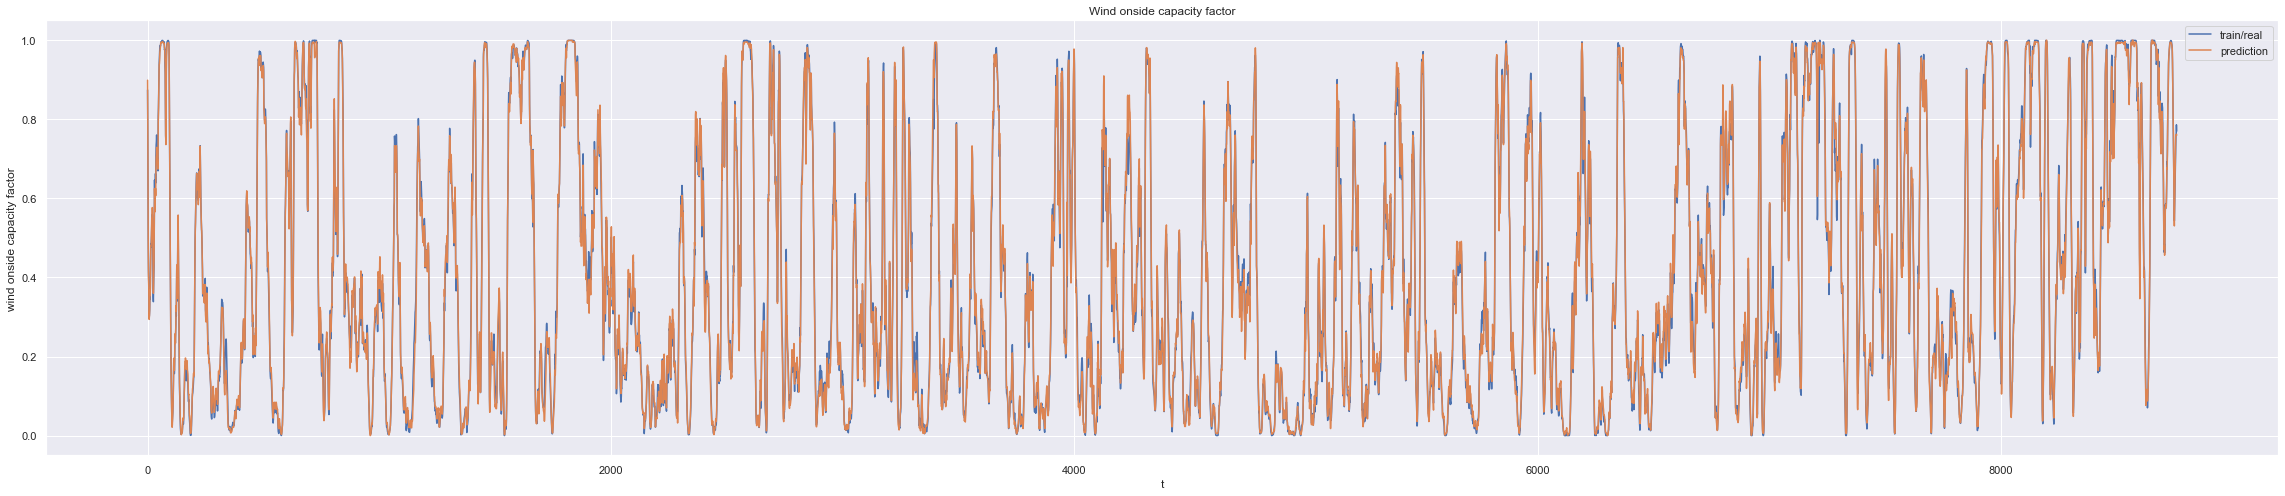

In [10]:
plt.figure(figsize=(40,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

Text(0.5, 1.0, 'wind capacity factor difference Denmark')

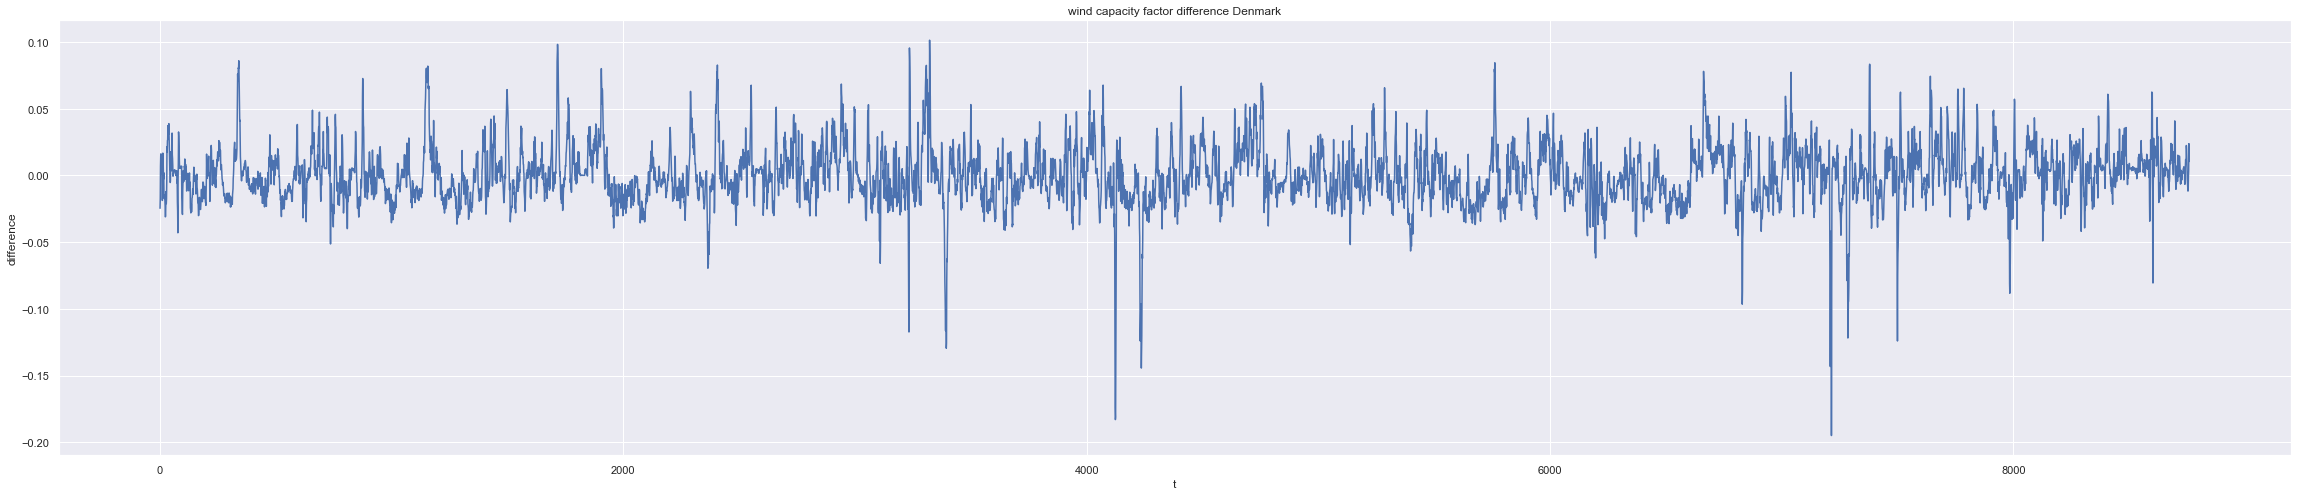

In [11]:
prediction_diff = Y_train - Y_preds

plt.figure(figsize=(40,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("wind capacity factor difference Denmark")

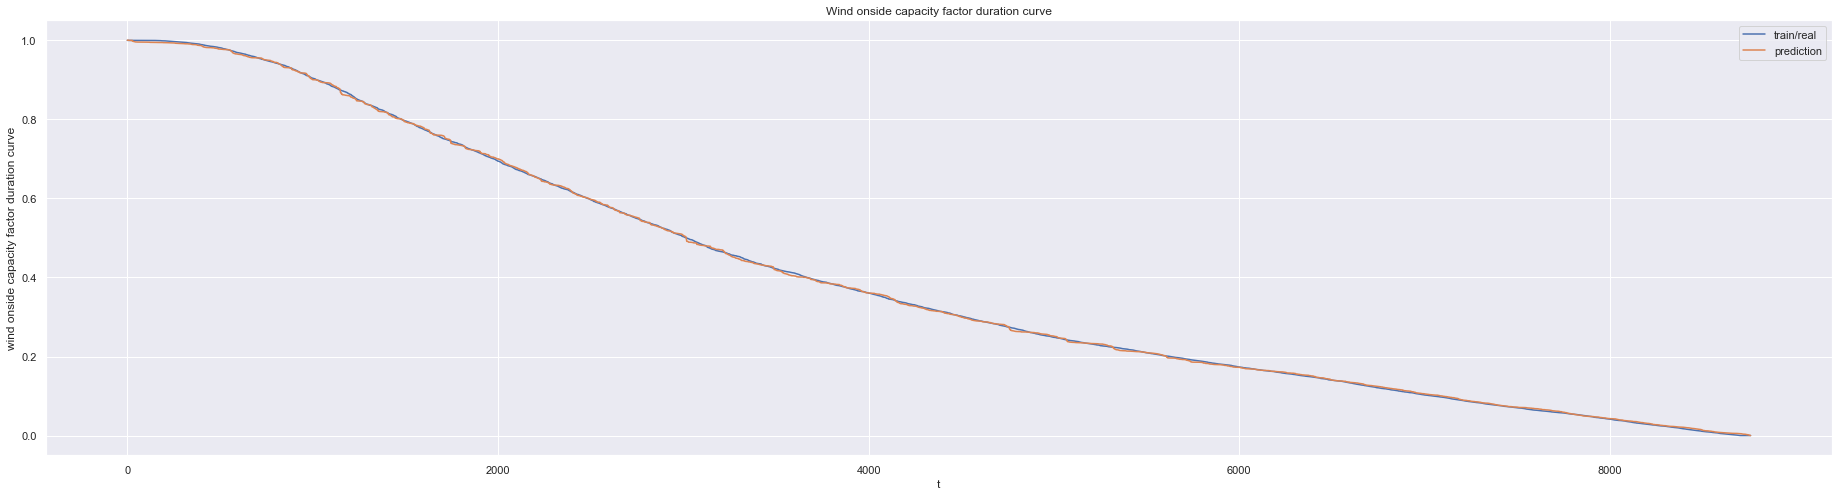

In [12]:
Y_preds_duration_curve = np.sort(Y_preds)[::-1]
Y_train_duration_curve = np.sort(Y_train)[::-1]

plt.figure(figsize=(32,8))
plt.plot(Y_train_duration_curve, label="train/real")
plt.plot(Y_preds_duration_curve, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor duration curve")
plt.title("Wind onside capacity factor duration curve")
plt.legend()

### Splitted Training and test set

In [13]:
Y, X = create_training_data_for_col("DK0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=0.2670 val_loss=0.0000 scale=1.0000 norm=0.5114
[iter 100] loss=-0.9064 val_loss=0.0000 scale=2.0000 norm=0.9248
[iter 200] loss=-1.7863 val_loss=0.0000 scale=2.0000 norm=0.8847
[iter 300] loss=-2.3214 val_loss=0.0000 scale=2.0000 norm=0.8638
[iter 400] loss=-2.5031 val_loss=0.0000 scale=2.0000 norm=0.9430


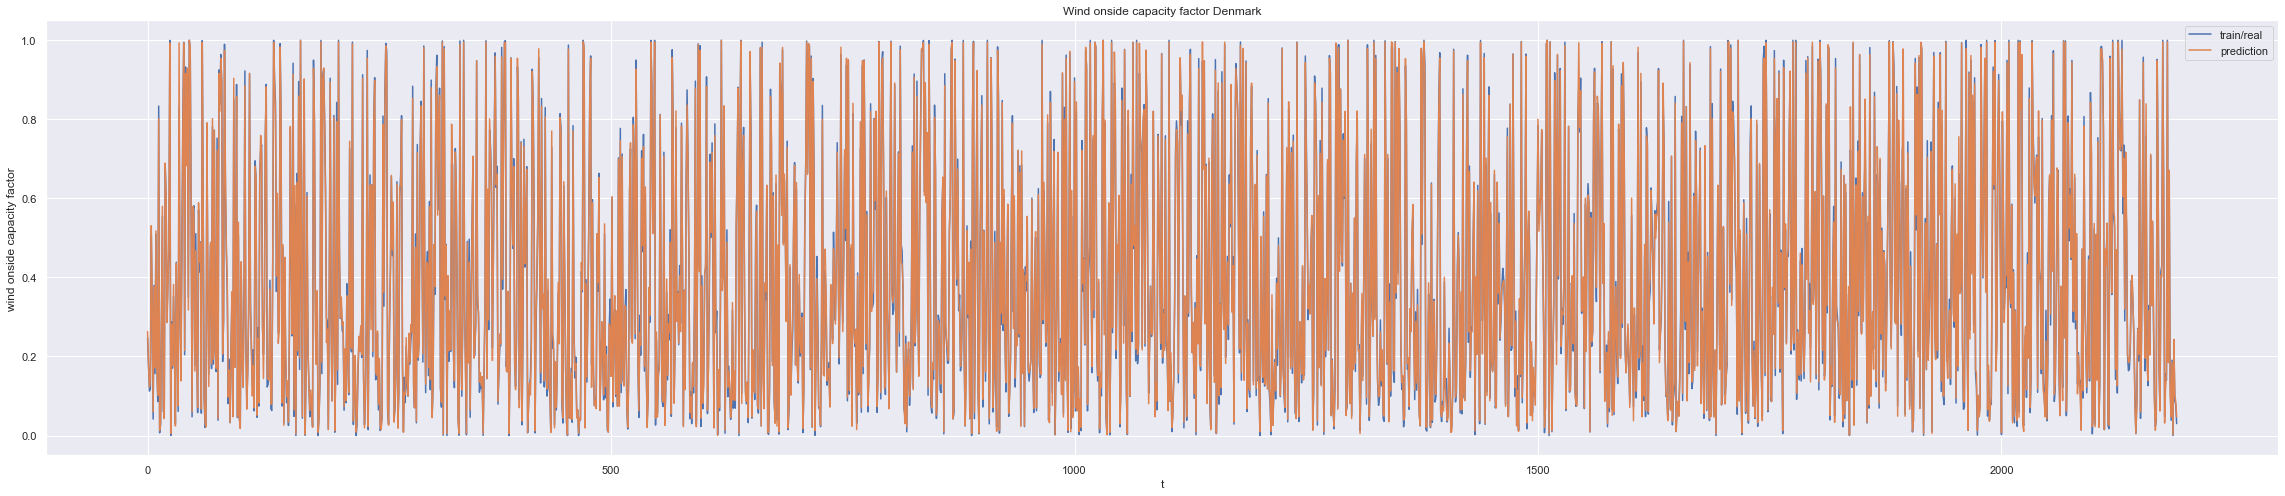

In [14]:
plt.figure(figsize=(40,8))
plt.plot(Y_test, label="train/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Denmark")
plt.legend()

Text(0.5, 1.0, 'wind capacity factor difference Denmark')

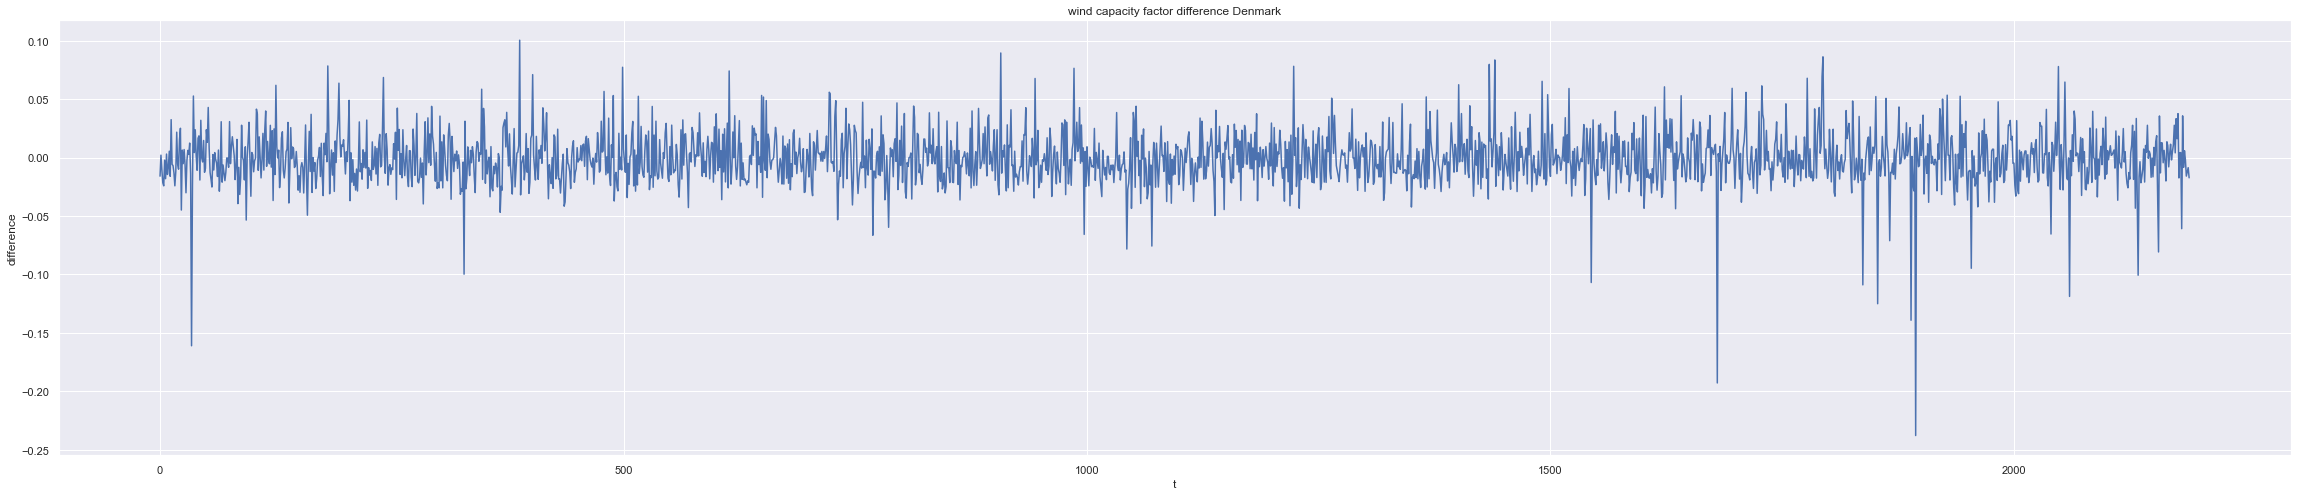

In [15]:
prediction_diff = Y_test - Y_preds

plt.figure(figsize=(40,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("wind capacity factor difference Denmark")

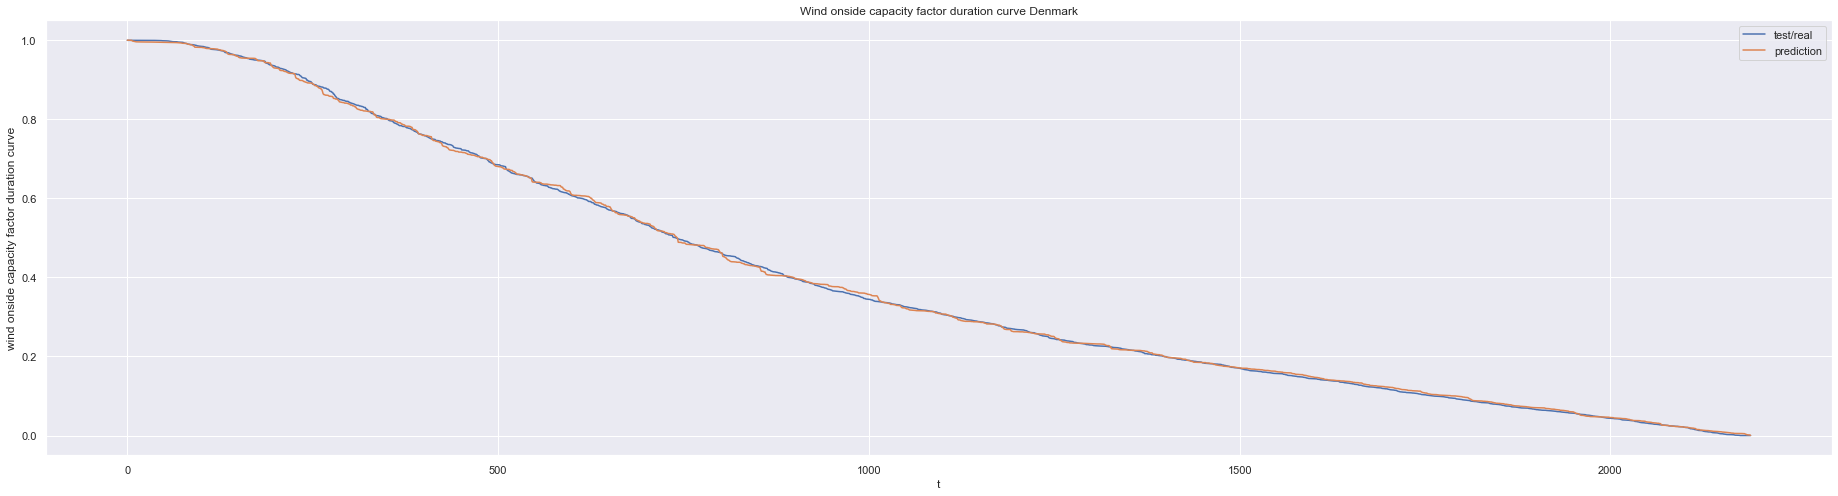

In [16]:
Y_preds_duration_curve = np.sort(Y_preds)[::-1]
Y_test_duration_curve = np.sort(Y_test)[::-1]

plt.figure(figsize=(32,8))
plt.plot(Y_test_duration_curve, label="test/real")
plt.plot(Y_preds_duration_curve, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor duration curve")
plt.title("Wind onside capacity factor duration curve Denmark")
plt.legend()

### Exponentioal Regression Distribution

In [17]:
Y, X = create_training_data_for_col("DK0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb_exp = NGBRegressor(Dist=Exponential, verbose=True).fit(X_train, Y_train)
Y_preds = ngb_exp.predict(X_test)
Y_dists = ngb_exp.pred_dist(X_test)

[iter 0] loss=0.0896 val_loss=0.0000 scale=2.0000 norm=1.3431
[iter 100] loss=-0.3032 val_loss=0.0000 scale=2.0000 norm=0.3802
[iter 200] loss=-0.3807 val_loss=0.0000 scale=2.0000 norm=0.2260
[iter 300] loss=-0.4001 val_loss=0.0000 scale=2.0000 norm=0.2069
[iter 400] loss=-0.4082 val_loss=0.0000 scale=4.0000 norm=0.4159


C:\Users\Thomas\miniconda3\envs\ma_probabilistic_forecasts\lib\site-packages\ngboost\distns\exponential.py:63: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\Thomas\miniconda3\envs\ma_probabilistic_forecasts\lib\site-packages\ngboost\distns\exponential.py:63: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


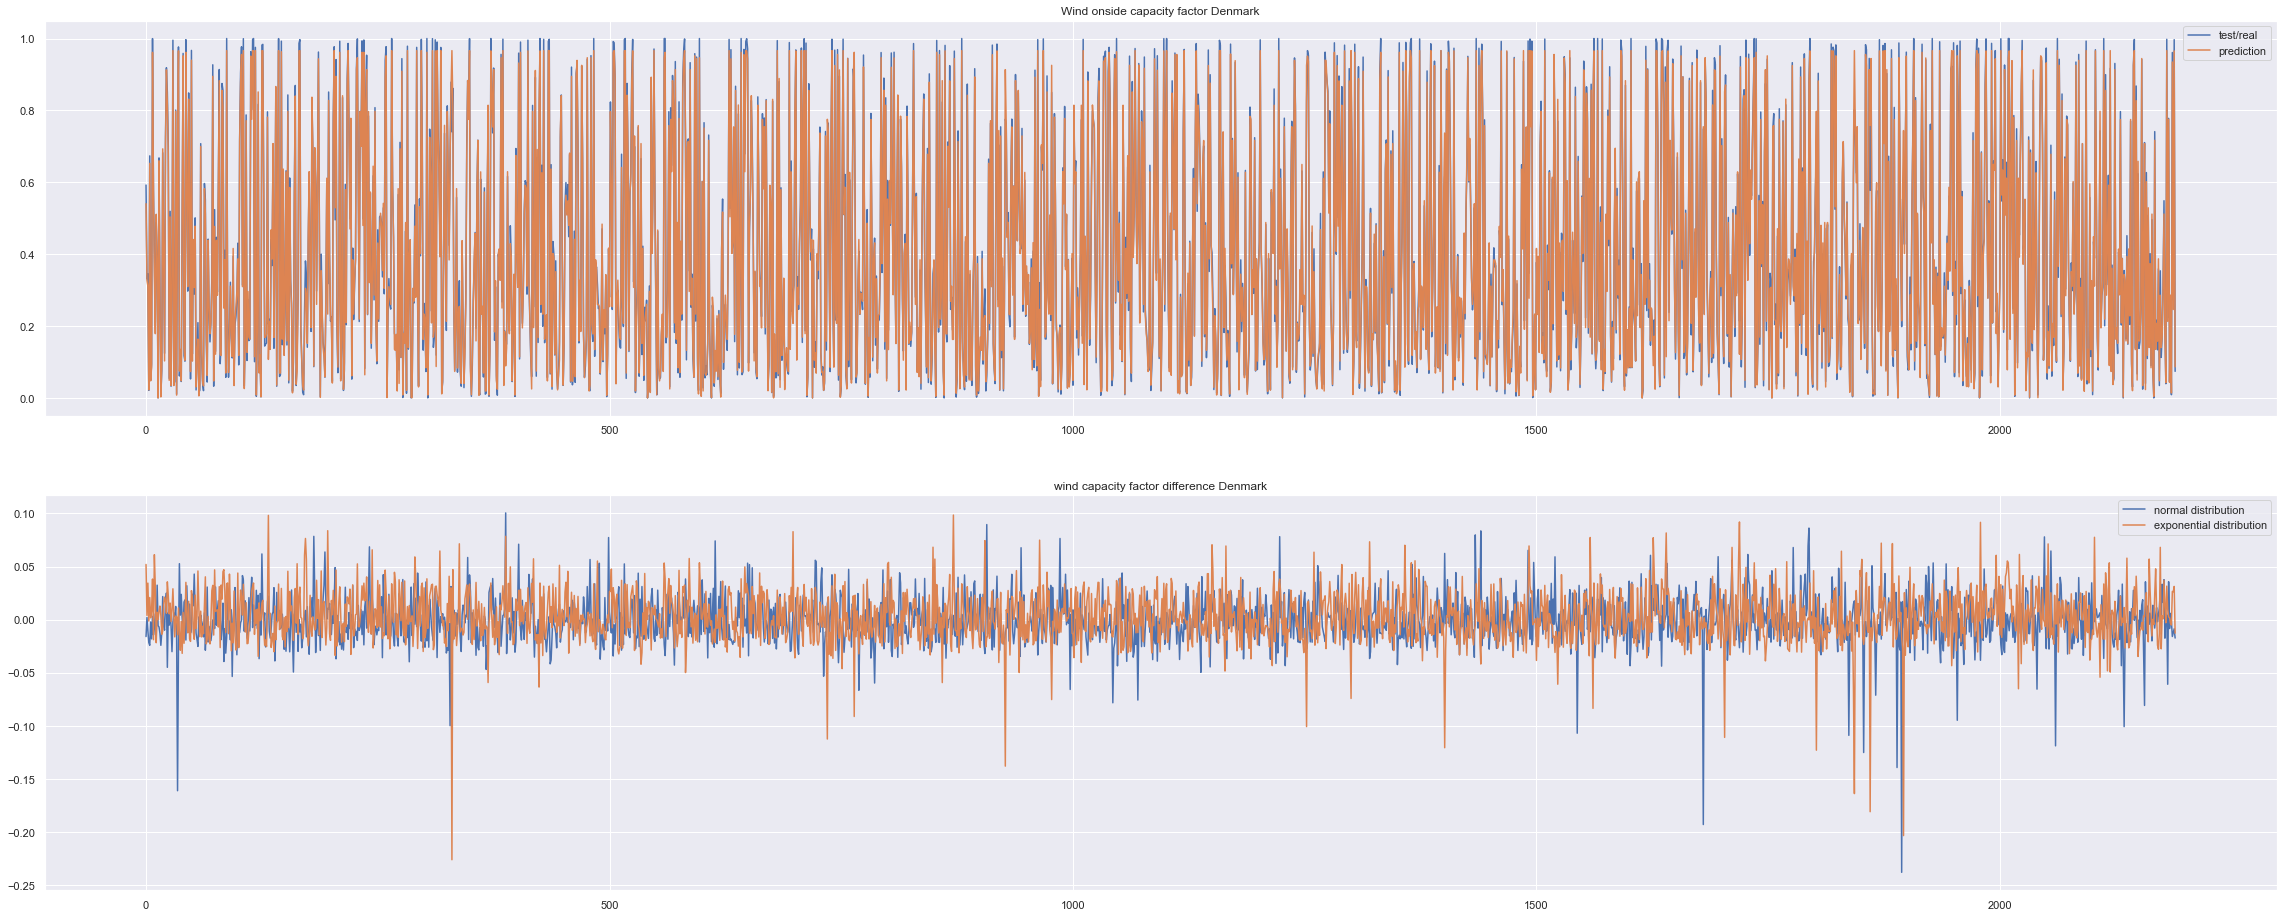

In [18]:
fig, ax = plt.subplots(2, figsize=(40,16))

ax[0].plot(Y_test, label="test/real")
ax[0].plot(Y_preds, label="prediction")
ax[0].set_title("Wind onside capacity factor Denmark")
ax[0].legend()

prediction_diff_exp = Y_test - Y_preds

ax[1].plot(prediction_diff, label="normal distribution")
ax[1].plot(prediction_diff_exp, label="exponential distribution")
ax[1].set_title("wind capacity factor difference Denmark")
ax[1].legend()

## NGBoost: Germany

In [19]:
find_countries_in_capfacts("DE")

['DE0 0 offwind-ac',
 'DE0 0 offwind-dc',
 'DE0 0 onwind',
 'DE0 0 ror',
 'DE0 0 solar']

[iter 0] loss=-0.1740 val_loss=0.0000 scale=1.0000 norm=0.5736
[iter 100] loss=-1.2683 val_loss=0.0000 scale=2.0000 norm=0.8457
[iter 200] loss=-1.8159 val_loss=0.0000 scale=2.0000 norm=0.8325
[iter 300] loss=-2.0379 val_loss=0.0000 scale=2.0000 norm=0.8733
[iter 400] loss=-2.0955 val_loss=0.0000 scale=1.0000 norm=0.4571


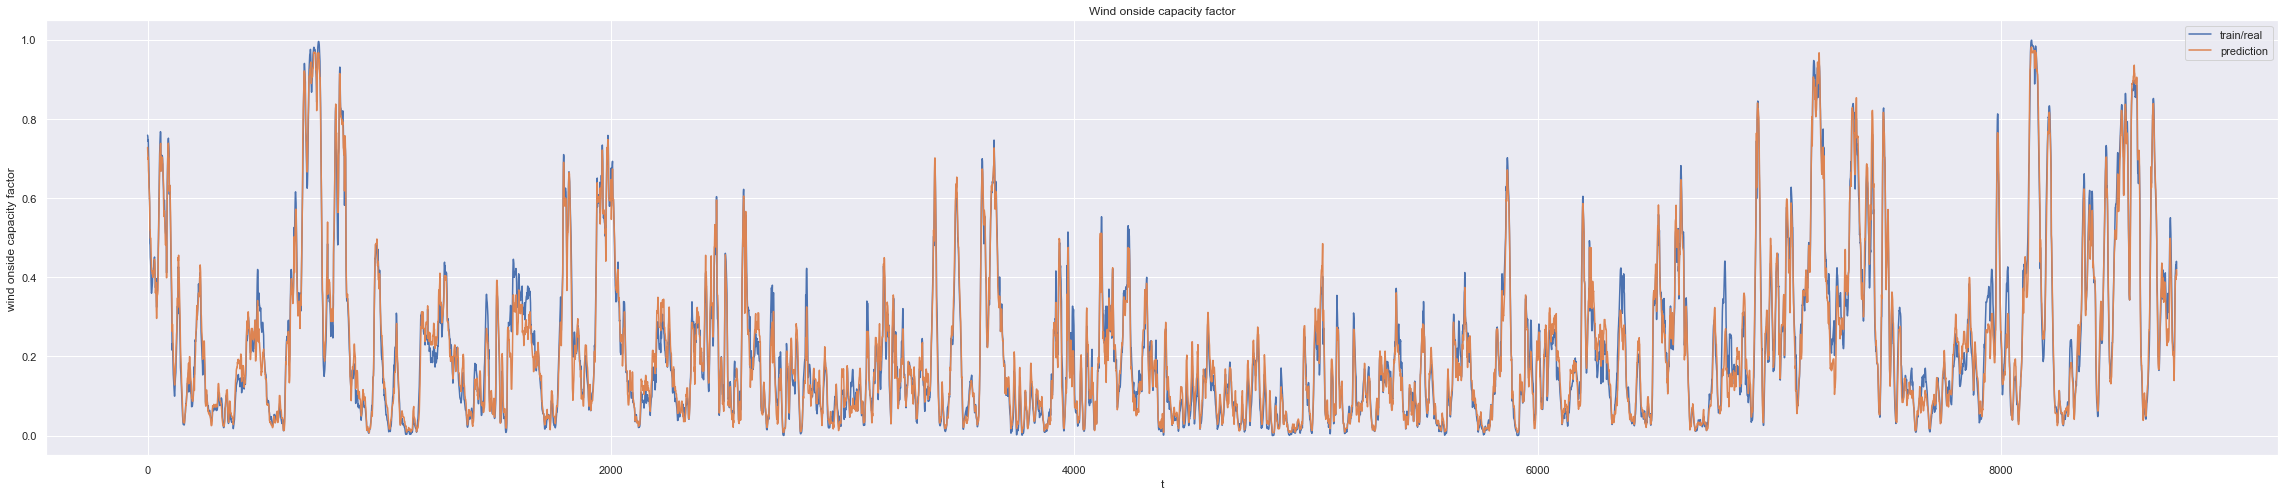

In [20]:
Y_capfac, X = create_training_data_for_col("DE0 0 onwind")

X_train = shape_multi_feature_data(X)
Y_train = Y_capfac

ngb = NGBRegressor().fit(X_train, Y_train)

Y_preds = ngb.predict(X_train)

plt.figure(figsize=(40,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

In [21]:
Y_dists = ngb.pred_dist(X_train)
Y_dists.params

{'loc': array([0.72755674, 0.71089024, 0.6975798 , ..., 0.39427589, 0.41858173,
        0.40439166]),
 'scale': array([0.03608833, 0.03428685, 0.03348949, ..., 0.03768654, 0.03741719,
        0.03791613])}

Text(0.5, 1.0, 'wind capacity factor difference Germany')

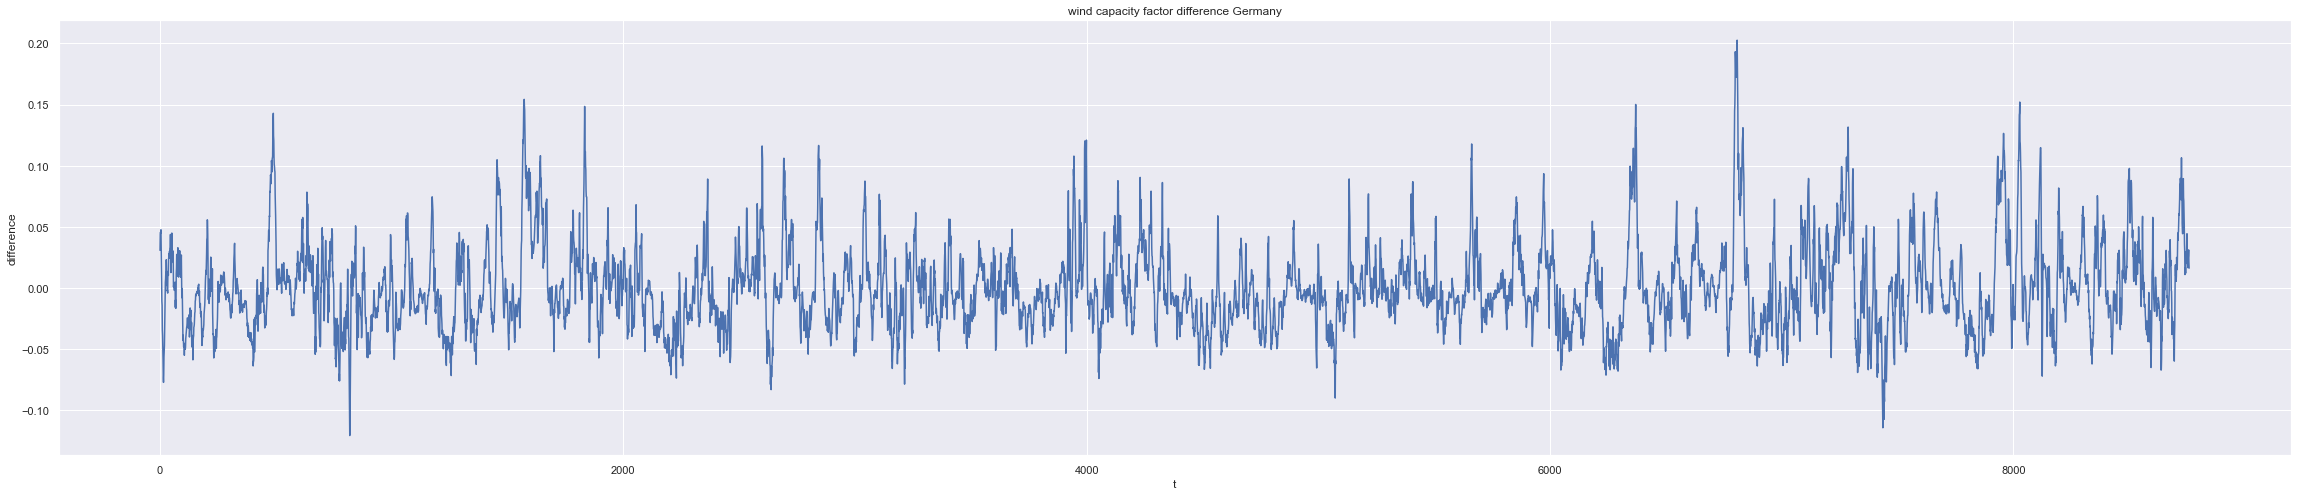

In [22]:
prediction_diff = Y_train - Y_preds

plt.figure(figsize=(40,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("wind capacity factor difference Germany")

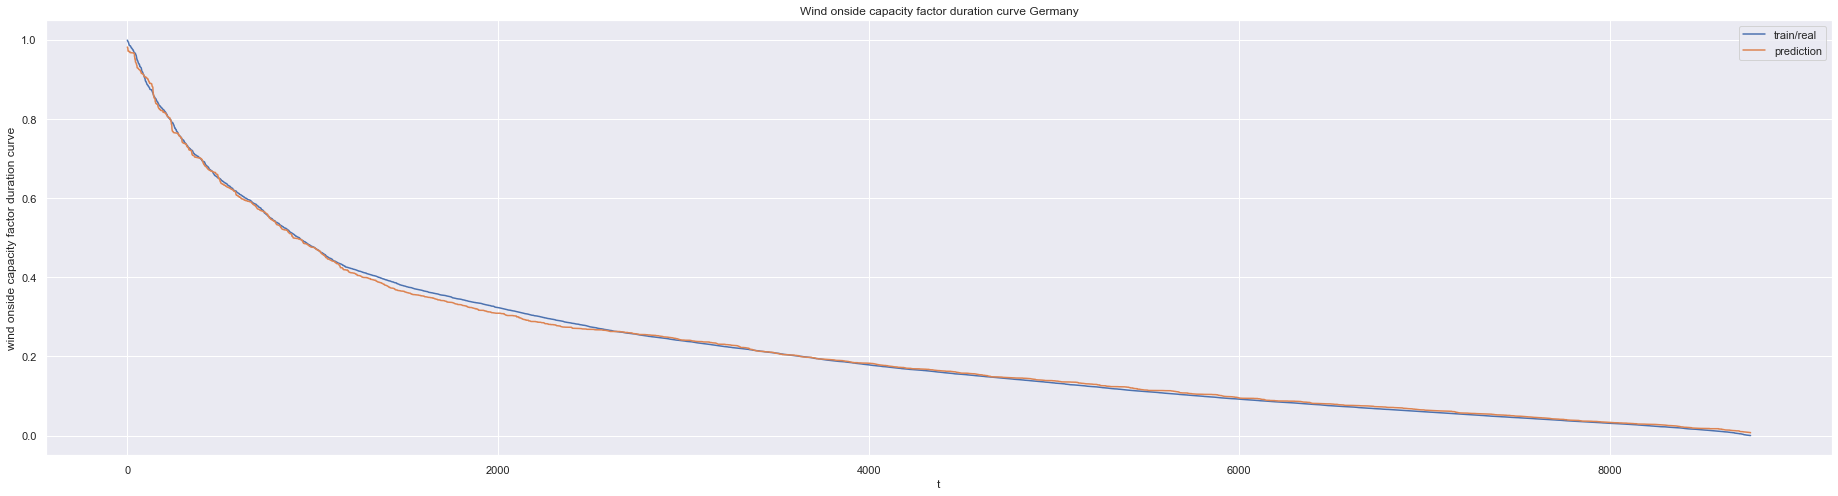

In [23]:
Y_preds_duration_curve = np.sort(Y_preds)[::-1]
Y_train_duration_curve = np.sort(Y_train)[::-1]

plt.figure(figsize=(32,8))
plt.plot(Y_train_duration_curve, label="train/real")
plt.plot(Y_preds_duration_curve, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor duration curve")
plt.title("Wind onside capacity factor duration curve Germany")
plt.legend()

### Splitted Training and test set

[iter 0] loss=-0.1693 val_loss=0.0000 scale=1.0000 norm=0.5748
[iter 100] loss=-1.2657 val_loss=0.0000 scale=2.0000 norm=0.8457
[iter 200] loss=-1.8183 val_loss=0.0000 scale=2.0000 norm=0.8322
[iter 300] loss=-2.0466 val_loss=0.0000 scale=2.0000 norm=0.8702
[iter 400] loss=-2.1056 val_loss=0.0000 scale=1.0000 norm=0.4554


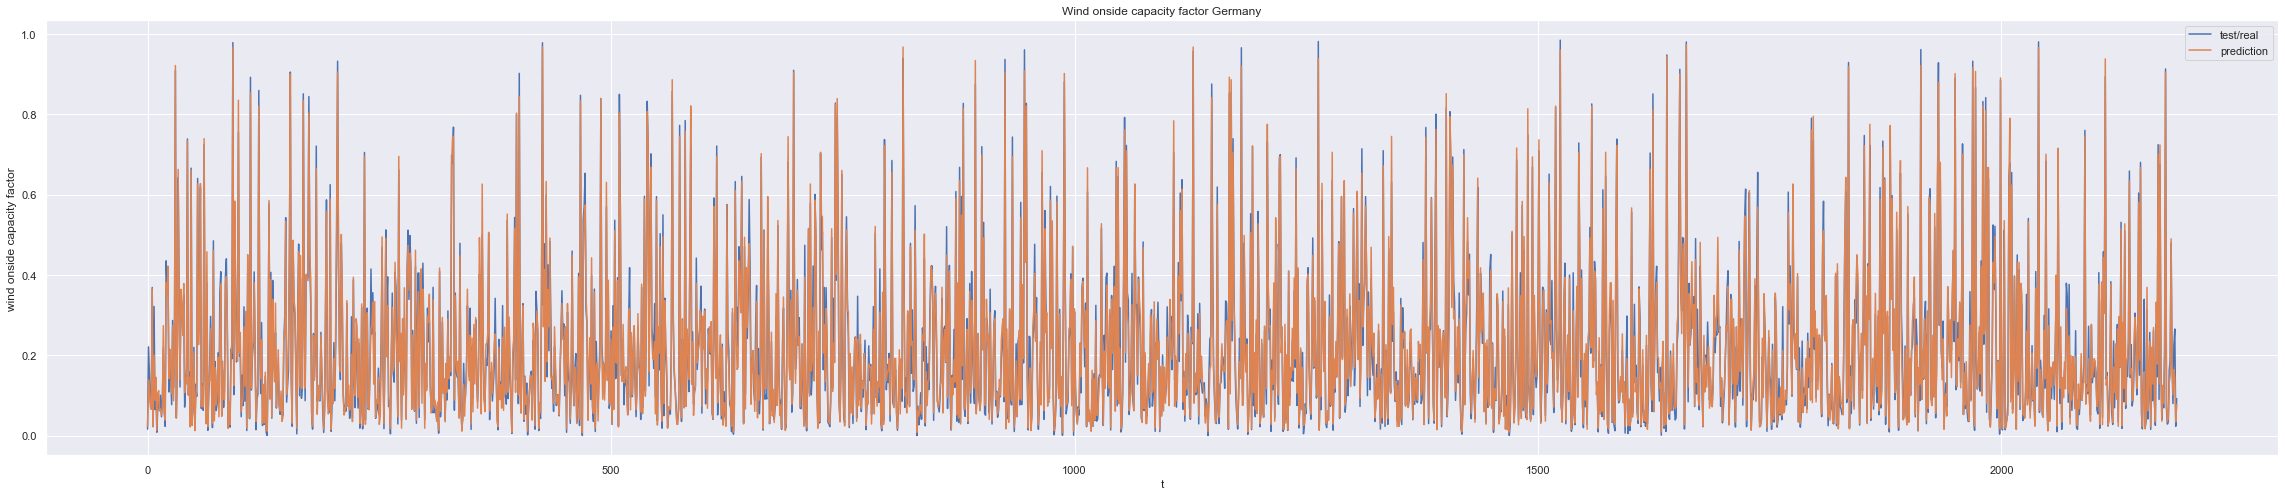

In [24]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

Text(0.5, 1.0, 'wind capacity factor difference Germany')

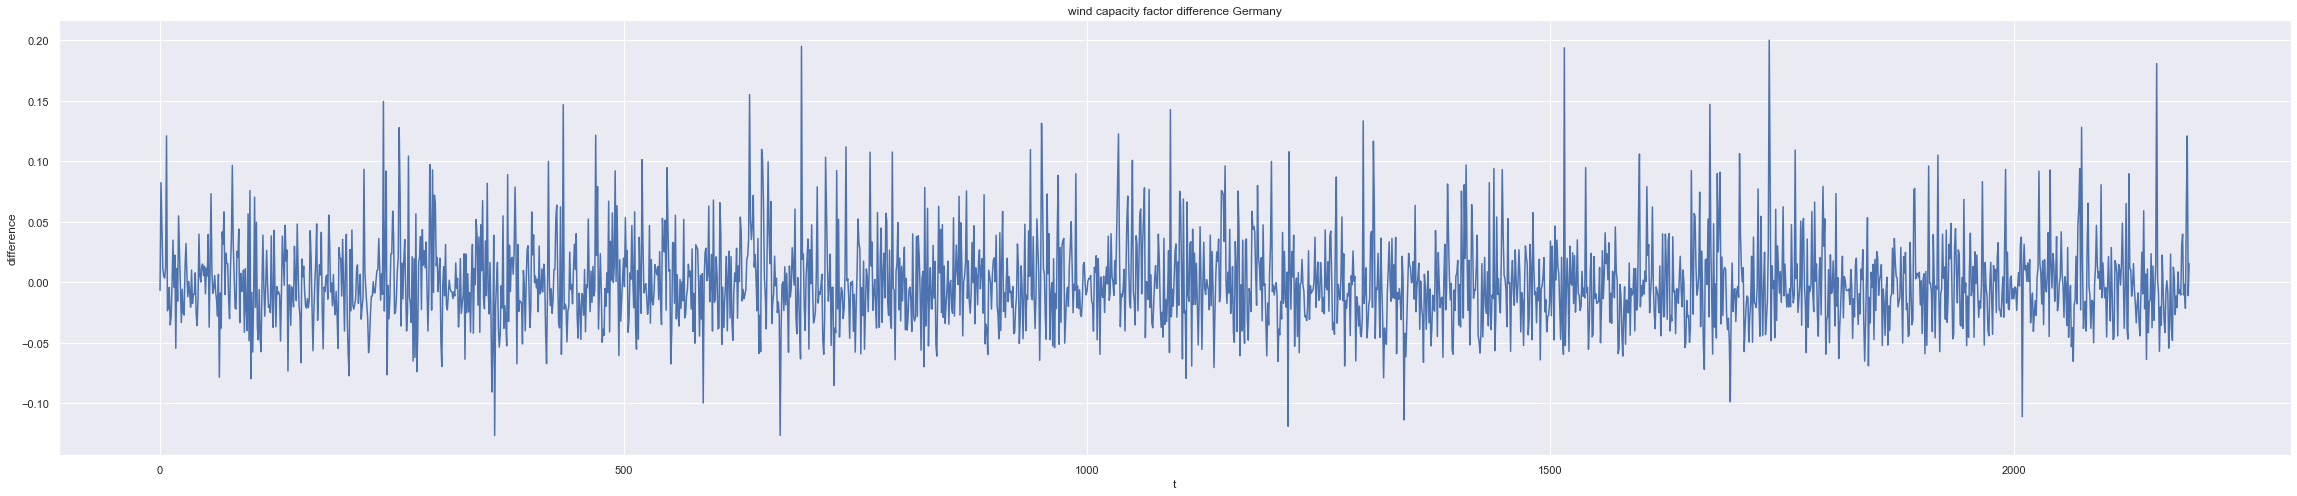

In [25]:
prediction_diff = Y_test - Y_preds

plt.figure(figsize=(40,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("wind capacity factor difference Germany")

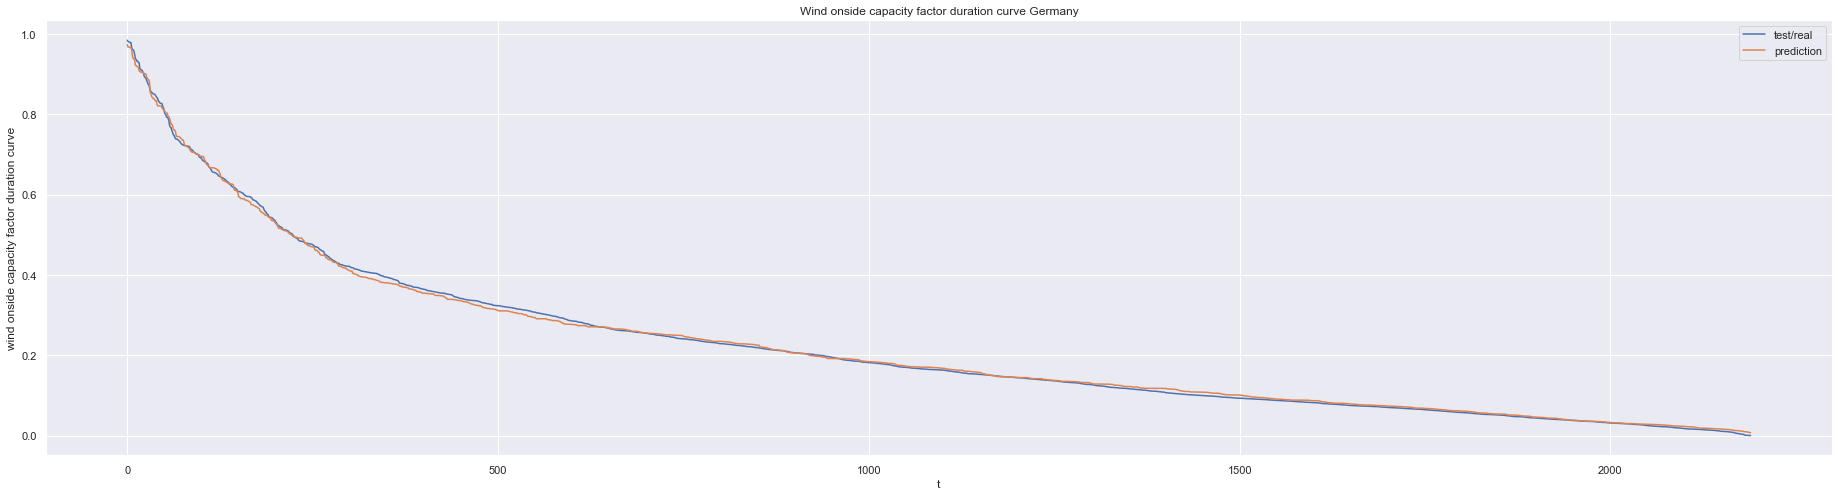

In [26]:
Y_preds_duration_curve = np.sort(Y_preds)[::-1]
Y_test_duration_curve = np.sort(Y_test)[::-1]

plt.figure(figsize=(32,8))
plt.plot(Y_test_duration_curve, label="test/real")
plt.plot(Y_preds_duration_curve, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor duration curve")
plt.title("Wind onside capacity factor duration curve Germany")
plt.legend()

## NGBoost: Germany Tuning Parameters

[iter 0] loss=-0.1698 val_loss=-0.2132 scale=1.0000 norm=0.5729
[iter 100] loss=-1.2655 val_loss=-1.2752 scale=2.0000 norm=0.8462
[iter 200] loss=-1.8180 val_loss=-1.8076 scale=2.0000 norm=0.8297
[iter 300] loss=-2.0430 val_loss=-2.0056 scale=2.0000 norm=0.8724
[iter 400] loss=-2.1048 val_loss=-2.0496 scale=1.0000 norm=0.4575
[iter 500] loss=-2.1263 val_loss=-2.0597 scale=1.0000 norm=0.4648
[iter 600] loss=-2.1459 val_loss=-2.0688 scale=1.0000 norm=0.4639
[iter 700] loss=-2.1602 val_loss=-2.0747 scale=1.0000 norm=0.4634
[iter 800] loss=-2.1713 val_loss=-2.0789 scale=1.0000 norm=0.4633
[iter 900] loss=-2.1801 val_loss=-2.0805 scale=1.0000 norm=0.4636
Iteration with best validation score:  875
875


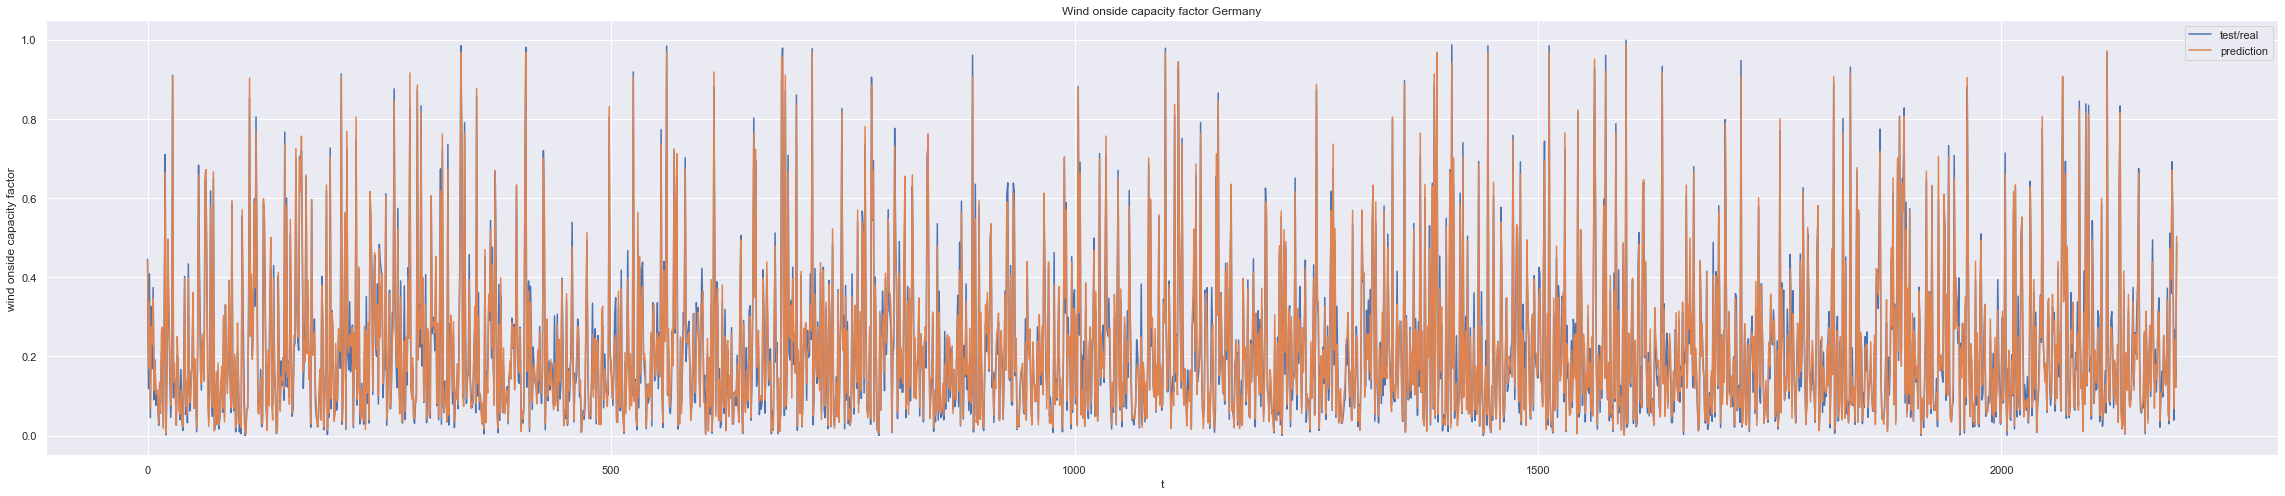

In [27]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

# ngb = NGBRegressor().fit(X_train, Y_train)
ngb = NGBRegressor(Dist=Normal, Score=LogScore, n_estimators=1000, verbose=True)
# ngb.fit(X_train, Y_train)
ngb.fit(X_train, Y_train, X_val=X_test, Y_val=Y_test) # use a validation set instead of test set
# ngb.fit(X_train, Y_train, X_val=X_test, Y_val=Y_test, early_stopping_rounds=2) # use a validation set instead of test set

print("Iteration with best validation score: ", ngb.best_val_loss_itr)

Y_preds = ngb.predict(X_test)
Y_preds_best = ngb.predict(X_test, max_iter=ngb.best_val_loss_itr)

# Staged prediction to see the results of all iterations
Y_staged_preds = ngb.staged_predict(X_test)
Y_preds_10 = Y_staged_preds[10]
Y_preds_100 = Y_staged_preds[100]
Y_preds_500 = Y_staged_preds[499]
Y_dists = ngb.pred_dist(X_test)
print(ngb.best_val_loss_itr)

plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

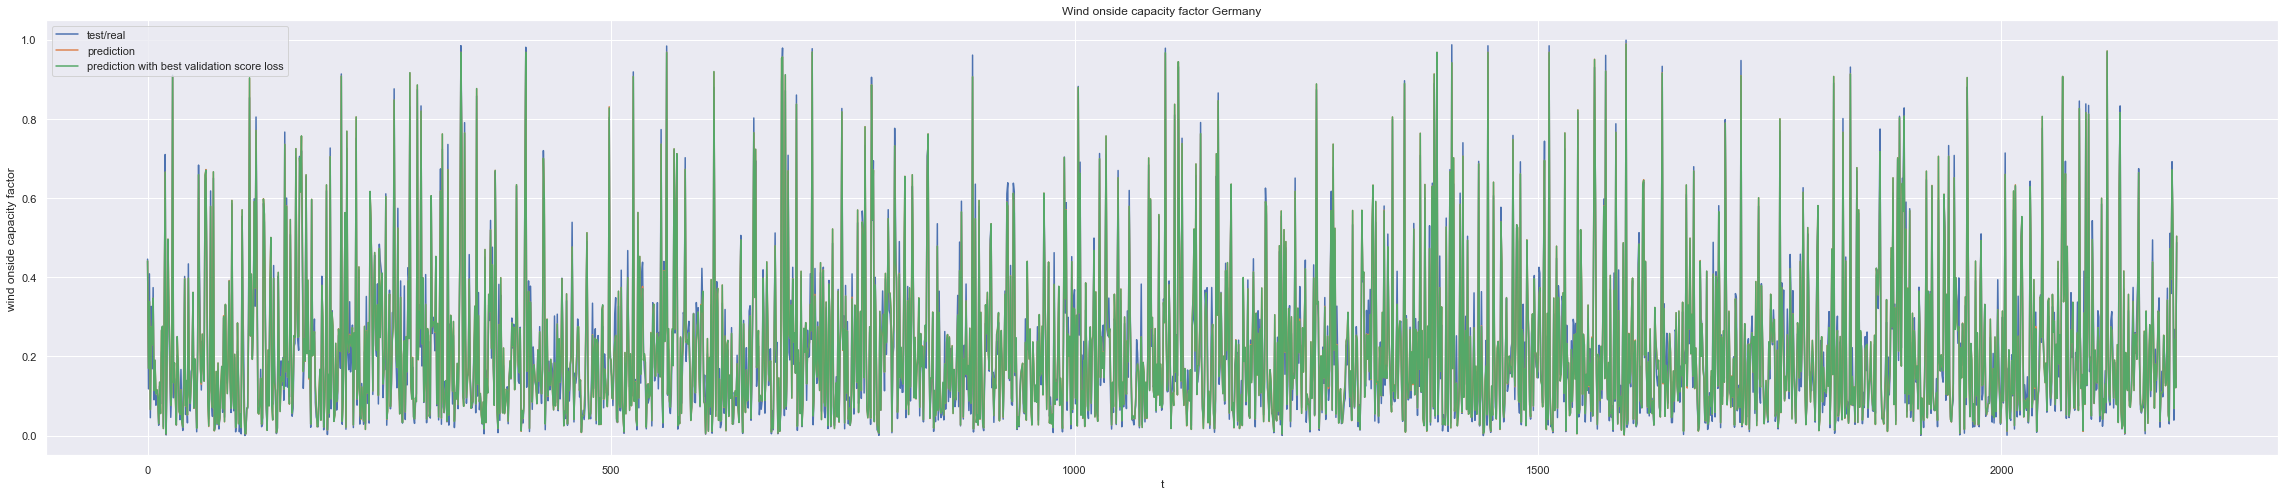

In [28]:
plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds, label="prediction")
# plt.plot(Y_preds_10, label="prediction 10 iterations")
# plt.plot(Y_preds_100, label="prediction 100 iterations")
# plt.plot(Y_preds_500, label="prediction 500 iterations")
plt.plot(Y_preds_best, label="prediction with best validation score loss")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

## NGBoost: Model Interpretation

[iter 0] loss=-0.1780 val_loss=0.0000 scale=1.0000 norm=0.5722
[iter 100] loss=-1.2713 val_loss=0.0000 scale=2.0000 norm=0.8459
[iter 200] loss=-1.8212 val_loss=0.0000 scale=2.0000 norm=0.8295
[iter 300] loss=-2.0465 val_loss=0.0000 scale=2.0000 norm=0.8676
[iter 400] loss=-2.1028 val_loss=0.0000 scale=2.0000 norm=0.9032


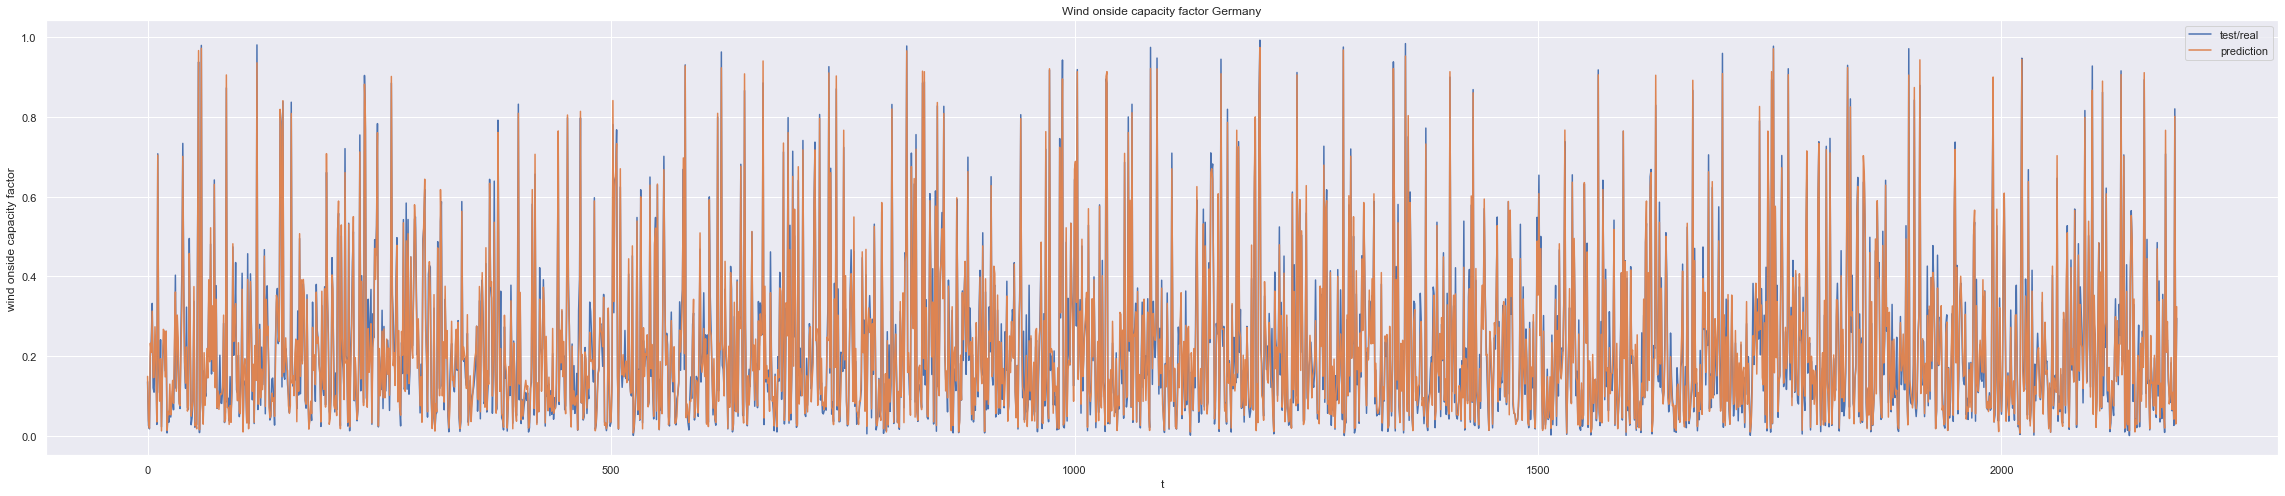

In [29]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)

## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

In [30]:
# percent point function
Y_preds_q25 = Y_dists.ppf(0.25)
Y_preds_q25

array([0.12375832, 0.02916533, 0.01306727, ..., 0.77933934, 0.02218411,
       0.30041975])

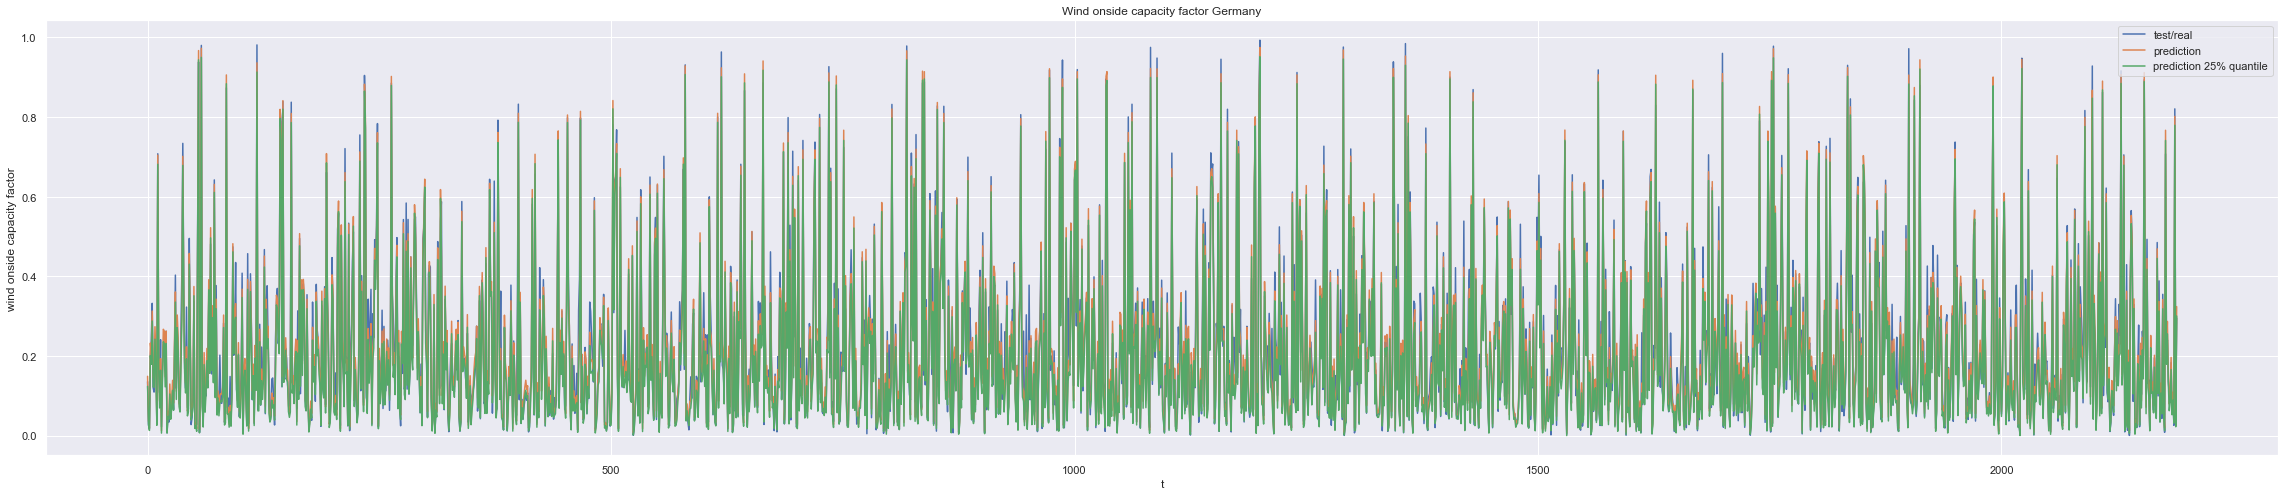

In [31]:
plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds, label="prediction")
plt.plot(Y_preds_q25, label="prediction 25% quantile")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

## NGBoost Prediction  results

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [32]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# plt.figure(figsize=(40,8))
# plt.plot(Y_test, label="test/real")
# plt.plot(Y_preds, label="prediction")
# plt.xlabel("t")
# plt.ylabel("wind onside capacity factor")
# plt.title("Wind onside capacity factor Germany")
# plt.legend()

[iter 0] loss=-0.1641 val_loss=0.0000 scale=1.0000 norm=0.5778
[iter 100] loss=-1.2650 val_loss=0.0000 scale=2.0000 norm=0.8471
[iter 200] loss=-1.8229 val_loss=0.0000 scale=2.0000 norm=0.8280
[iter 300] loss=-2.0511 val_loss=0.0000 scale=2.0000 norm=0.8647
[iter 400] loss=-2.1120 val_loss=0.0000 scale=2.0000 norm=0.9054


### Point Percent function

*(dt. Verallgemeinerte inverse Verteilungsfuntion* (see [Wikipedia](https://en.wikipedia.org/wiki/Quantile_function)

In [33]:
# percent point function
Y_preds_q25 = Y_dists.ppf(0.25)
Y_preds_q25

array([0.09043959, 0.21020455, 0.24842789, ..., 0.06916935, 0.23981799,
       0.13835313])

In [34]:
loc1 = Y_dists.loc[0]
scale1=Y_dists.scale[0]
print(loc1, scale1)
print(Y_preds_q25[0])
print(norm.ppf(0.25))
norm.ppf(0.5, loc=loc1, scale=scale1)

0.11441887271768893 0.0355517332949858
0.09043959300851623
-0.6744897501960817


0.11441887271768893

### Prediction Analysis

val_loss: validation loss

In [35]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)


[iter 0] loss=-0.1694 val_loss=0.0000 scale=1.0000 norm=0.5757
[iter 100] loss=-1.2646 val_loss=0.0000 scale=2.0000 norm=0.8468
[iter 200] loss=-1.8210 val_loss=0.0000 scale=2.0000 norm=0.8302
[iter 300] loss=-2.0490 val_loss=0.0000 scale=2.0000 norm=0.8708
[iter 400] loss=-2.1119 val_loss=0.0000 scale=1.0000 norm=0.4585


In [36]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

#### Confidence Intervall

In [37]:
# 80% confidence intervall
Y_preds_q10 = Y_dists.ppf(0.1)
Y_preds_q90 = Y_dists.ppf(0.9)
print(coverage_fraction(Y_test, Y_preds_q10, Y_preds_q90))

# 90% confidence intervall
Y_preds_q05 = Y_dists.ppf(0.05)
Y_preds_q95 = Y_dists.ppf(0.95)
print(coverage_fraction(Y_test, Y_preds_q05, Y_preds_q95))

0.8191780821917808
0.9


#### Pinball loss and mean squared error


In [38]:
# Y_preds_q50 = Y_preds (point prediction)
Y_preds_q50 = Y_dists.ppf(0.5)
print("MSE: " , mean_squared_error(Y_test, Y_preds))

# Pinball loss for q=0.4
Y_preds_q40 = Y_dists.ppf(0.4)
print("PL q=0.4:", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.4))

# Pinball loss for q=0.6
Y_preds_q60 = Y_dists.ppf(0.6)
print("PL q=0.6: ", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.6))

MSE:  0.001387244606044638
PL q=0.4: 0.012797149199582965
PL q=0.6:  0.014300904812986286


In [39]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# plt.figure(figsize=(40,8))
# plt.plot(Y_test, label="test/real")
# plt.plot(Y_preds, label="prediction")
# plt.xlabel("t")
# plt.ylabel("wind onside capacity factor")
# plt.title("Wind onside capacity factor Germany")
# plt.legend()

[iter 0] loss=-0.1681 val_loss=0.0000 scale=1.0000 norm=0.5760
[iter 100] loss=-1.2647 val_loss=0.0000 scale=2.0000 norm=0.8466
[iter 200] loss=-1.8154 val_loss=0.0000 scale=2.0000 norm=0.8317
[iter 300] loss=-2.0422 val_loss=0.0000 scale=2.0000 norm=0.8712
[iter 400] loss=-2.1013 val_loss=0.0000 scale=2.0000 norm=0.9099


### Point Percent function

*(dt. Verallgemeinerte inverse Verteilungsfuntion* (see [Wikipedia](https://en.wikipedia.org/wiki/Quantile_function)

In [40]:
# percent point function
Y_preds_q25 = Y_dists.ppf(0.25)
Y_preds_q25

array([0.17608407, 0.49258431, 0.07158424, ..., 0.12236232, 0.53863077,
       0.36662079])

In [41]:
loc1 = Y_dists.loc[0]
scale1=Y_dists.scale[0]
print(loc1, scale1)
print(Y_preds_q25[0])
print(norm.ppf(0.25))
norm.ppf(0.5, loc=loc1, scale=scale1)

0.20864280834283955 0.04827166218604609
0.1760840669734237
-0.6744897501960817


0.20864280834283955

### Prediction Analysis

val_loss: validation loss

In [42]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)


[iter 0] loss=-0.1700 val_loss=0.0000 scale=1.0000 norm=0.5759
[iter 100] loss=-1.2709 val_loss=0.0000 scale=2.0000 norm=0.8455
[iter 200] loss=-1.8218 val_loss=0.0000 scale=2.0000 norm=0.8313
[iter 300] loss=-2.0489 val_loss=0.0000 scale=2.0000 norm=0.8675
[iter 400] loss=-2.1100 val_loss=0.0000 scale=2.0000 norm=0.9073


In [43]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

#### Confidence Intervall

In [44]:
# 80% confidence intervall
Y_preds_q10 = Y_dists.ppf(0.1)
Y_preds_q90 = Y_dists.ppf(0.9)
print(coverage_fraction(Y_test, Y_preds_q10, Y_preds_q90))

# 90% confidence intervall
Y_preds_q05 = Y_dists.ppf(0.05)
Y_preds_q95 = Y_dists.ppf(0.95)
print(coverage_fraction(Y_test, Y_preds_q05, Y_preds_q95))

0.8356164383561644
0.9045662100456621


#### Pinball loss and mean squared error


In [45]:
# Y_preds_q50 = Y_preds (point prediction)
Y_preds_q50 = Y_dists.ppf(0.5)
print("MSE: " , mean_squared_error(Y_test, Y_preds))

# Pinball loss for q=0.4
Y_preds_q40 = Y_dists.ppf(0.4)
print("PL q=0.4:", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.4))

# Pinball loss for q=0.6
Y_preds_q60 = Y_dists.ppf(0.6)
print("PL q=0.6: ", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.6))

MSE:  0.001369988811965995
PL q=0.4: 0.012534623320805452
PL q=0.6:  0.014294020465282824


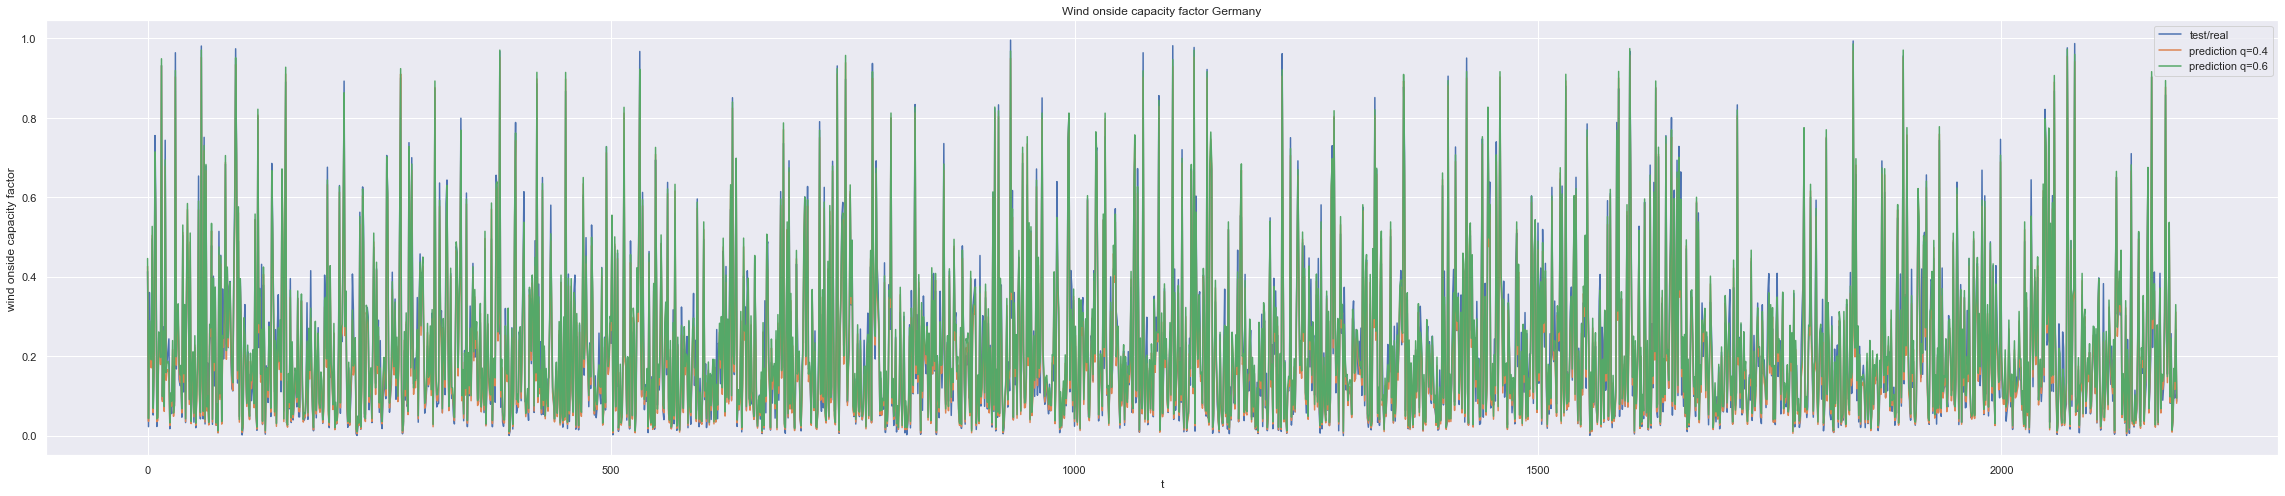

In [46]:
plt.figure(figsize=(40,8))
plt.plot(Y_test, label="test/real")
plt.plot(Y_preds_q40, label="prediction q=0.4")
plt.plot(Y_preds_q60, label="prediction q=0.6")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

In [47]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# plt.figure(figsize=(40,8))
# plt.plot(Y_test, label="test/real")
# plt.plot(Y_preds, label="prediction")
# plt.xlabel("t")
# plt.ylabel("wind onside capacity factor")
# plt.title("Wind onside capacity factor Germany")
# plt.legend()

[iter 0] loss=-0.1722 val_loss=0.0000 scale=1.0000 norm=0.5715
[iter 100] loss=-1.2725 val_loss=0.0000 scale=2.0000 norm=0.8477
[iter 200] loss=-1.8241 val_loss=0.0000 scale=2.0000 norm=0.8333
[iter 300] loss=-2.0495 val_loss=0.0000 scale=2.0000 norm=0.8708
[iter 400] loss=-2.1085 val_loss=0.0000 scale=1.0000 norm=0.4558


### Point Percent function

*(dt. Verallgemeinerte inverse Verteilungsfuntion* (see [Wikipedia](https://en.wikipedia.org/wiki/Quantile_function)

In [48]:
# percent point function
Y_preds_q25 = Y_dists.ppf(0.25)
Y_preds_q25

array([0.25129857, 0.22929264, 0.38144089, ..., 0.11204993, 0.01145647,
       0.05270591])

In [49]:
loc1 = Y_dists.loc[0]
scale1=Y_dists.scale[0]
print(loc1, scale1)
print(Y_preds_q25[0])
print(norm.ppf(0.25))
norm.ppf(0.5, loc=loc1, scale=scale1)

0.2824507225364857 0.04618624537799071
0.2512985734289898
-0.6744897501960817


0.2824507225364857

### Prediction Analysis

val_loss: validation loss

In [50]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)


[iter 0] loss=-0.1804 val_loss=0.0000 scale=1.0000 norm=0.5740
[iter 100] loss=-1.2695 val_loss=0.0000 scale=2.0000 norm=0.8458
[iter 200] loss=-1.8166 val_loss=0.0000 scale=2.0000 norm=0.8339
[iter 300] loss=-2.0381 val_loss=0.0000 scale=2.0000 norm=0.8734
[iter 400] loss=-2.0959 val_loss=0.0000 scale=1.0000 norm=0.4562


In [51]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

#### Confidence Intervall

In [52]:
# 80% confidence intervall
Y_preds_q10 = Y_dists.ppf(0.1)
Y_preds_q90 = Y_dists.ppf(0.9)
print(coverage_fraction(Y_test, Y_preds_q10, Y_preds_q90))
print(coverage_fraction(Y_test[0:30], Y_preds_q10[0:30], Y_preds_q90[0:30]))

# 90% confidence intervall
Y_preds_q05 = Y_dists.ppf(0.05)
Y_preds_q95 = Y_dists.ppf(0.95)
print(coverage_fraction(Y_test, Y_preds_q05, Y_preds_q95))
print(coverage_fraction(Y_test[0:30], Y_preds_q05[0:30], Y_preds_q95[0:30]))

0.8301369863013699
0.9666666666666667
0.9164383561643835
1.0


#### Pinball loss and mean squared error


In [53]:
# Y_preds_q50 = Y_preds (point prediction)
Y_preds_q50 = Y_dists.ppf(0.5)
print("MSE: " , mean_squared_error(Y_test, Y_preds))

# Pinball loss for q=0.4
Y_preds_q40 = Y_dists.ppf(0.4)
print("PL q=0.4:", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.4))

# Pinball loss for q=0.6
Y_preds_q60 = Y_dists.ppf(0.6)
print("PL q=0.6: ", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.6))

MSE:  0.0013034609896000436
PL q=0.4: 0.0123985856592467
PL q=0.6:  0.014204270855710879


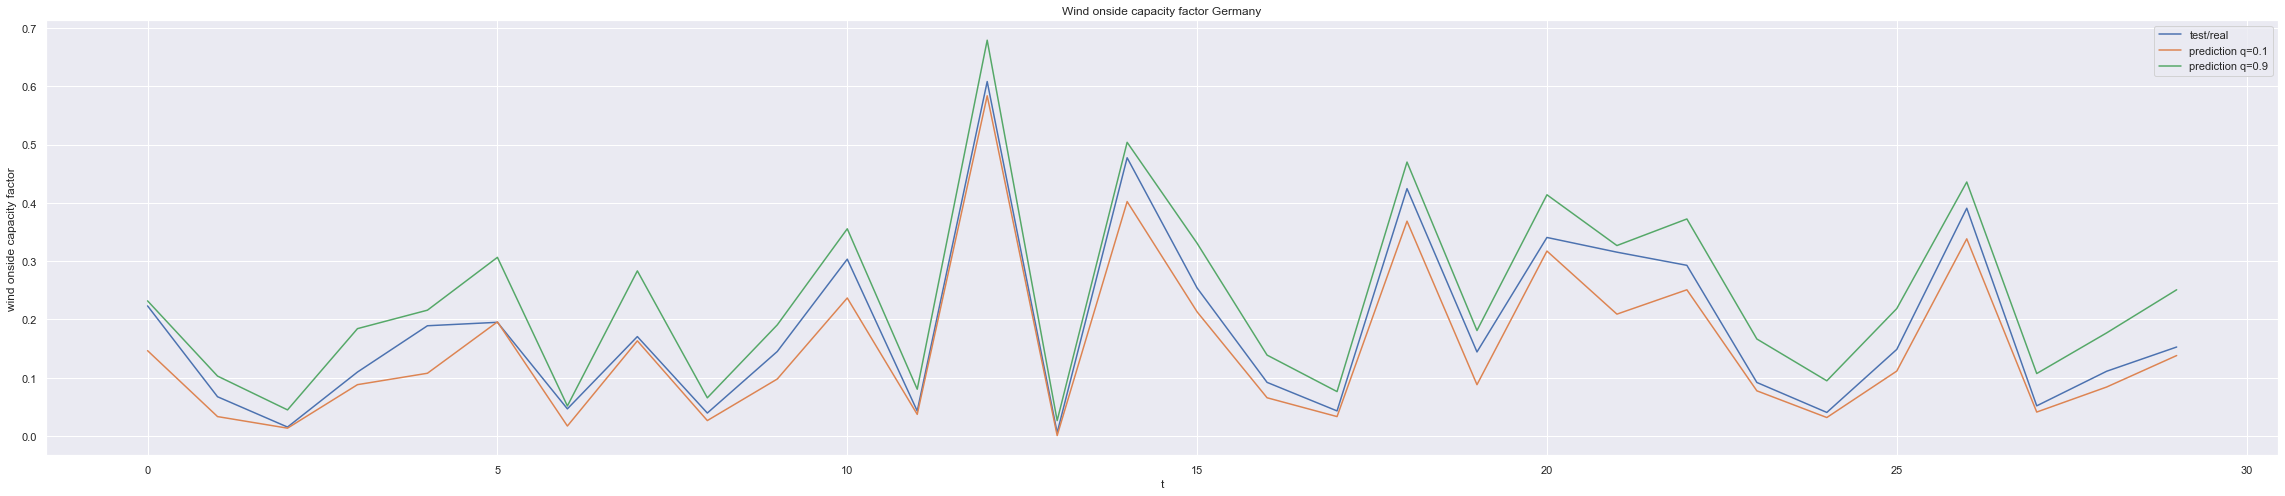

In [54]:
plt.figure(figsize=(40,8))
plt.plot(Y_test[0:30], label="test/real")
# plt.plot(Y_preds_q40[:40], label="prediction q=0.4")
# plt.plot(Y_preds_q60[:40], label="prediction q=0.6")
plt.plot(Y_preds_q10[0:30], label="prediction q=0.1")
plt.plot(Y_preds_q90[0:30], label="prediction q=0.9")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor Germany")
plt.legend()

In [55]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# plt.figure(figsize=(40,8))
# plt.plot(Y_test, label="test/real")
# plt.plot(Y_preds, label="prediction")
# plt.xlabel("t")
# plt.ylabel("wind onside capacity factor")
# plt.title("Wind onside capacity factor Germany")
# plt.legend()

[iter 0] loss=-0.1729 val_loss=0.0000 scale=1.0000 norm=0.5726
[iter 100] loss=-1.2720 val_loss=0.0000 scale=2.0000 norm=0.8471
[iter 200] loss=-1.8202 val_loss=0.0000 scale=2.0000 norm=0.8349
[iter 300] loss=-2.0445 val_loss=0.0000 scale=2.0000 norm=0.8706
[iter 400] loss=-2.1014 val_loss=0.0000 scale=2.0000 norm=0.9130


### Point Percent function

*(dt. Verallgemeinerte inverse Verteilungsfuntion* (see [Wikipedia](https://en.wikipedia.org/wiki/Quantile_function)

In [56]:
# percent point function
Y_preds_q25 = Y_dists.ppf(0.25)
Y_preds_q25

array([0.36835957, 0.06840456, 0.62544015, ..., 0.34819709, 0.02387871,
       0.22921774])

In [57]:
loc1 = Y_dists.loc[0]
scale1=Y_dists.scale[0]
print(loc1, scale1)
print(Y_preds_q25[0])
print(norm.ppf(0.25))
norm.ppf(0.5, loc=loc1, scale=scale1)

0.39318036717875676 0.03679936267583265
0.3683595742401594
-0.6744897501960817


0.39318036717875676

### NLL

In [58]:
Y, X = create_training_data_for_col("DE0 0 onwind")

X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)


[iter 0] loss=-0.1760 val_loss=0.0000 scale=1.0000 norm=0.5765
[iter 100] loss=-1.2704 val_loss=0.0000 scale=2.0000 norm=0.8490
[iter 200] loss=-1.8255 val_loss=0.0000 scale=2.0000 norm=0.8370
[iter 300] loss=-2.0514 val_loss=0.0000 scale=2.0000 norm=0.8808
[iter 400] loss=-2.1126 val_loss=0.0000 scale=1.0000 norm=0.4586


In [59]:
# Y_preds_q50 = Y_preds (point prediction)
Y_preds_q50 = Y_dists.ppf(0.5)
print("MSE: " , mean_squared_error(Y_test, Y_preds))

# Pinball loss for q=0.4
Y_preds_q40 = Y_dists.ppf(0.4)
print("PL q=0.4:", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.4))

# Pinball loss for q=0.6
Y_preds_q60 = Y_dists.ppf(0.6)
print("PL q=0.6: ", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.6))

MSE:  0.0014134357885933336
PL q=0.4: 0.013034071618146917
PL q=0.6:  0.014892665755113343


In [64]:
-Y_dists.logpdf(Y_test).mean()

-2.0195496778915523